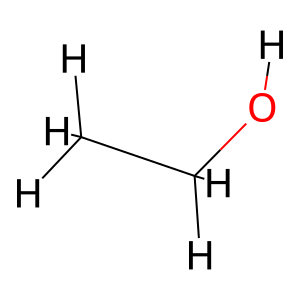

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

# Define the SMILES string
smiles = 'CCO'  # Example: Ethanol

# Create a molecule object from the SMILES string
molecule = Chem.MolFromSmiles(smiles)

# Add hydrogens to the molecule
molecule = Chem.AddHs(molecule)

# Generate 3D coordinates
AllChem.EmbedMolecule(molecule, randomSeed=42)
ff = AllChem.UFFOptimizeMolecule(molecule)

# Display the molecule
Draw.MolToImage(molecule)

In [2]:
from ase import Atoms
import nglview as nv

# Function to convert RDKit molecule to ASE Atoms object
def rdkit_to_ase(molecule):
    conformer = molecule.GetConformer()
    symbols = [atom.GetSymbol() for atom in molecule.GetAtoms()]
    positions = [conformer.GetAtomPosition(atom.GetIdx()) for atom in molecule.GetAtoms()]
    positions = [(pos.x, pos.y, pos.z) for pos in positions]
    ase_atoms = Atoms(symbols=symbols, positions=positions)
    return ase_atoms

at = rdkit_to_ase(molecule)
view = nv.show_ase(at)
view.add_representation('label', 
                        selection='*', 
                        labelType='atomindex', 
                        color='black',
                        zOffset=1.0)
view

NGLWidget()

In [5]:
from mace import data, tools

Rcut = 4.0
Nmax = 4


z_table = tools.AtomicNumberTable([1, 6, 8])

config = data.Configuration(
    atomic_numbers=at.numbers,
    positions=at.positions
)

data = data.AtomicData.from_config(config, z_table=z_table, cutoff=Rcut)

In [6]:
from mace.modules.utils import get_edge_vectors_and_lengths

vectors, lengths = get_edge_vectors_and_lengths(
    positions=data["positions"],
    edge_index=data["edge_index"],
    shifts=data["shifts"],
)

In [7]:
data.__dict__

{'x': None,
 'edge_index': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
          3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
          6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8],
         [1, 2, 3, 4, 5, 6, 7, 8, 0, 2, 3, 4, 5, 6, 7, 8, 0, 1, 3, 4, 5, 6, 7, 8,
          0, 1, 2, 4, 5, 6, 7, 8, 0, 1, 2, 3, 5, 6, 7, 8, 0, 1, 2, 3, 4, 6, 7, 8,
          0, 1, 2, 3, 4, 5, 7, 8, 0, 1, 2, 3, 4, 5, 6, 8, 0, 1, 2, 3, 4, 5, 6, 7]]),
 'edge_attr': None,
 'y': None,
 'pos': None,
 'normal': None,
 'face': None,
 '__num_nodes__': 9,
 'positions': tensor([[-0.9257,  0.0738,  0.0244],
         [ 0.5132, -0.4192, -0.0683],
         [ 1.3722,  0.4522,  0.6151],
         [-1.0191,  1.0710, -0.4556],
         [-1.5998, -0.6393, -0.4952],
         [-1.2334,  0.1504,  1.0888],
         [ 0.8161, -0.5095, -1.1362],
         [ 0.5825, -1.4258,  0.3954],
         [ 1.4939,  1.2463,  0.0317]]),
 'shifts': tensor([[0.

$$
h_{i,k00}^{(0)} = \sum_z W_{kz} \delta_{zzi}
$$

$$
\tilde{h}_{i,k_1l_2m_2}^{(s)} = \sum_k W_{kk_1}^{(s)} h_{i,k_2l_2m_2}^{(s)}
$$

$$
j_{0}^{n}(r_{ij}) = \sqrt{\frac{2}{r_{\text{cut}}}} \frac{\sin \left( \pi n \frac{r_{ij}}{r_{\text{cut}}} \right)}{r_{ij}} f_{\text{cut}}(r_{ij})
$$

$$
R_{k\eta_1l_1l_2l_3}^{(s)}(r_{ij}) = \text{MLP} \left( \left\{ j_{0}^{n}(r_{ij}) \right\}_n \right)
$$

$$
\phi_{ij,k\eta_1l_3m_3}^{(s)} = \sum_{l_1l_2m_1m_2} c_{l_3m_3}^{\eta_1m_1l_1m_2} R_{k\eta_1l_1l_2l_3}^{(s)}(r_{ij}) \times Y_{l_1}^{m_1}(\hat{r}_{ij}) \tilde{h}_{j,k_2l_2m_2}^{(s)}
$$

$$
A_{i,k_1l_3m_3}^{(s)} = \sum_{\tilde{k}\eta1} W_{kk\eta1}^{(s)} \sum_{j \in \mathcal{N}(i)} \phi_{ij,k\eta_1l_3m_3}^{(s)}
$$

$$
A_{i,klm}^{(s), \nu} = \prod_{\xi=1}^{\nu} A_{i,k\xi lm2}^{(s)}
$$

$$
B_{i,\eta\gamma kLM}^{(s), \nu} = \sum_{lm} C_{LM}^{\nu lm} A_{i,klm}^{(s), \nu}
$$

## 1. Species embedding

$$
h_{i,k00}^{(0)} = \sum_z W_{kz} \delta_{zzi}
$$


In [8]:
import torch
from mace import tools

z_table = tools.get_atomic_number_table_from_zs(at.numbers)
num_elements = len(z_table)

indices = tools.utils.atomic_numbers_to_indices(at.numbers, z_table=z_table)
indices_torch = torch.tensor(indices, dtype=torch.int64).unsqueeze(-1)
node_attrs = tools.torch_tools.to_one_hot(indices_torch,num_classes=num_elements)

print(node_attrs)

tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])


In [9]:
# import torch
# import torch.nn as nn

# model = nn.Sequential()

# model.add_module('W0', nn.Linear(8, 16))
# model.add_module('tanh', nn.Tanh())
# model.add_module('W1', nn.Linear(16, 1))

# x = torch.randn(100, 8)
# y = model(x)

## 2. Radial Basis
$$
j_{0}^{n}(r_{ij}) = \sqrt{\frac{2}{r_{\text{cut}}}} \frac{\sin \left( \pi n \frac{r_{ij}}{r_{\text{cut}}} \right)}{r_{ij}} f_{\text{cut}}(r_{ij})
$$

In [10]:
from mace.modules.blocks import BesselBasis

bessel_fn = BesselBasis(r_max=Rcut, num_basis=Nmax)

In [11]:
radial = bessel_fn(lengths)

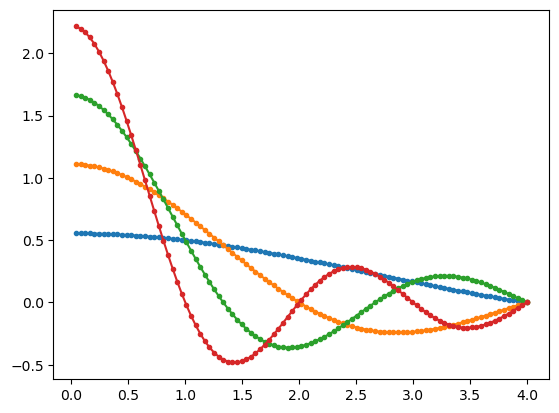

In [15]:
import numpy as np
from matplotlib import pyplot as plt

dists = np.linspace(0,Rcut,100).reshape(-1,1)
plt.plot(dists, bessel_fn(dists), '.-');